In [1]:
import os
import time
import matplotlib.pyplot as plt
import pdb
import pandas as pd
import pickle

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
)
from monai.utils import set_determinism
from tqdm import tqdm

import torch
from torch.utils.data import Subset

from utils.dataset import BraTSDataset
from utils.model import create_SegResNet, inference
from utils.transforms import tumor_seg_transform

# print_config()

In [2]:
from utils.logger import Logger
logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [4]:
USE_PROCESSED = False
RANDOM_SEED = 0

In [5]:
set_determinism(seed=RANDOM_SEED)

In [6]:
train_dataset = BraTSDataset(
    version='2017',
    processed = USE_PROCESSED,
    section = 'training',
    seed = RANDOM_SEED,
    transform = tumor_seg_transform['train']
)

val_dataset = BraTSDataset(
    version='2017',
    processed = USE_PROCESSED,
    section = 'validation',
    seed = RANDOM_SEED,
    transform = tumor_seg_transform['val']
)

logger.debug("Data loaded")
logger.debug(f"Length of dataset: {len(train_dataset)}, {len(val_dataset)}")

[DEBUG] Data loaded
[DEBUG] Length of dataset: 386, 97
[DEBUG] Batch-size: 2, 2
[DEBUG] Length of data-loaders: 193, 49


In [9]:
ids_ = train_dataset.ids
ids_.sort()
print(ids_)

[  1   2   3   4   6   7   8   9  10  13  14  15  16  17  18  19  20  23
  24  25  26  27  28  30  31  32  34  35  36  37  38  39  40  42  43  44
  45  46  47  48  49  50  51  53  54  55  56  57  58  62  64  66  67  69
  70  72  74  77  78  79  80  81  82  83  84  86  87  89  92  93  94  95
  96  98 100 101 103 104 105 106 108 110 111 112 113 114 116 117 118 119
 120 121 122 123 124 125 126 127 129 130 131 132 133 134 135 136 137 138
 139 140 142 144 145 146 147 148 149 150 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 168 169 170 171 174 176 177 178 179 180 181
 182 183 184 185 186 188 190 192 193 195 197 198 201 202 203 204 205 206
 207 208 209 210 212 215 216 217 218 220 221 222 224 226 227 228 230 231
 232 233 234 235 236 237 239 240 241 243 244 245 246 247 249 250 251 252
 253 254 256 257 258 259 260 261 262 265 266 267 268 269 270 271 273 274
 275 276 277 279 280 281 282 283 285 286 287 288 291 292 294 295 296 297
 299 300 301 302 303 304 306 307 309 310 311 313 31

In [13]:
brain_slice = train_dataset[0]['image']
print(brain_slice.shape)

torch.Size([4, 64, 64, 64])


In [14]:
brain_slice = val_dataset[0]['image']
print(brain_slice.shape)

torch.Size([4, 240, 240, 155])


torch.Size([240, 240])


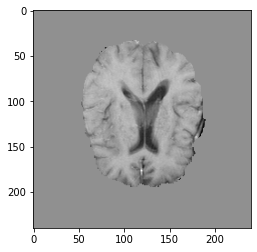

In [32]:
import numpy as np
id_ = 75
ids_ = val_dataset.ids
this_data = val_dataset[np.where(ids_ == id_)[0][0]]
brain_slice = val_dataset[0]['image'][1][...,77].T
print(brain_slice.shape)
plt.imshow(brain_slice, cmap='gray')